In [19]:
'''
This is to build a model which aligns the image of the camera with steering 
input to centre the car in the lane

It requires images with relevant steering inputs already generated
'''
import keras
import os
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, concatenate, Embedding, Reshape, Flatten, Activation
from keras.optimizers import SGD
import numpy as np

#constants to resize image to
HEIGHT = 360
WIDTH = 640

#get a lsit of files
mypath = 'C:/SelfDrive/_out'
only_images = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".png")]
only_steering = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".str")]
# get a list when both are available: image and steering
complete_names = set(only_images).intersection(only_steering)

# read training data 

X = [] #images
Y = [] #expected steering for this image
for example in complete_names:
    img_path = mypath+'/'+example+'.png'
    str_path = mypath+'/'+example+'.str'
     
    image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    
    X.append(image[:, :, None] / 255) # adding another dimension and normalising pixels to 0-1
    # max value of Y during writing of this was 0.79 so no need to convert it to 0-1
    
    f = open(str_path,'r')
    y = f.readline()
    Y.append(float(y))

X = np.array(X)
Y = np.array(Y)

In [21]:
model = Sequential()
model.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(HEIGHT, WIDTH,1)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])


model.fit(X, Y, batch_size=32, epochs=3, validation_split=0.3)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 360, 640, 8)       80        
                                                                 
 activation_6 (Activation)   (None, 360, 640, 8)       0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 180, 320, 8)      0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 460800)            0         
                                                                 
 dense_4 (Dense)             (None, 32)                14745632  
                                                                 
 activation_7 (Activation)   (None, 32)                0         
                                                      

In [ ]:
# need to get to 0.002 and below to be within 5% ish

In [1]:
'''
next iteration:

deal with activation at the end to allow negative values - by re-scaling Y labels to center around 0.5

focus on certain screen area

'''
import keras
import os
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, concatenate, Embedding, Reshape, Flatten, Activation
from keras.optimizers import SGD
import numpy as np

#constants to resize image to
HEIGHT = 360
WIDTH = 640

HEIGHT_REQUIRED_PORTION = 0.4 #bottom share, e.g. 0.1 is take lowest 10% of rows
WIDTH_REQUIRED_PORTION = 0.5

height_from = int(HEIGHT * (1 -HEIGHT_REQUIRED_PORTION))
width_from = int((WIDTH - WIDTH * WIDTH_REQUIRED_PORTION) / 2)
width_to = width_from + int(WIDTH_REQUIRED_PORTION * WIDTH)

#get a lsit of files
mypath = 'C:/SelfDrive/_out'
only_images = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".png")]
only_steering = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".str")]
# get a list when both are available: image and steering
complete_names = set(only_images).intersection(only_steering)

# read training data 

X = [] #images
Y = [] #expected steering for this image
for example in complete_names:
    img_path = mypath+'/'+example+'.png'
    str_path = mypath+'/'+example+'.str'
     
    image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    # this version adds taking lower side of the image
    image = image[height_from:,width_from:width_to]
    
    X.append(image[:, :, None] / 255) # adding another dimension and normalising pixels to 0-1
    # max value of Y during writing of this was 0.79 so no need to convert it to 0-1
    
    f = open(str_path,'r')
    y = f.readline()
    Y.append(float(y))

X = np.array(X)
Y = np.array(Y)
Y = Y/2 + 0.5 # transforming Y from [-1:+1] to [0:1]

In [3]:
#initial model giving good results - needs to be checked against a real driving scenario
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())  
model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])


model.fit(X, Y, batch_size=32, epochs=5, validation_split=0.2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 144, 320, 64)      640       
                                                                 
 activation_5 (Activation)   (None, 144, 320, 64)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 72, 160, 64)      0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 160, 64)       36928     
                                                                 
 activation_6 (Activation)   (None, 72, 160, 64)       0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 80, 64)       0         
 2D)                                                  

In [2]:
#adding an extra layer - no difference - not saved
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())  
model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])


model.fit(X, Y, batch_size=32, epochs=3, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 320, 64)      640       
                                                                 
 activation (Activation)     (None, 144, 320, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 72, 160, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 160, 64)       36928     
                                                                 
 activation_1 (Activation)   (None, 72, 160, 64)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 80, 64)       0         
 2D)                                                    

In [2]:
cv2.imshow("image", image)
cv2.waitKey(0)

-1

In [4]:
#saving model
model.save("lane_model_360x640_04_05", overwrite=False,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

INFO:tensorflow:Assets written to: lane_model_360x640_04_05\assets


INFO:tensorflow:Assets written to: lane_model_360x640_04_05\assets


In [1]:
'''
next iteration:

use angle against the lane rather than steering wheel as a more accurate label

Note new source folder

'''
import keras
import os
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, concatenate, Embedding, Reshape, Flatten, Activation
from keras.optimizers import SGD
import numpy as np

#constants to resize image to
HEIGHT = 360
WIDTH = 640

HEIGHT_REQUIRED_PORTION = 0.4 #bottom share, e.g. 0.1 is take lowest 10% of rows
WIDTH_REQUIRED_PORTION = 0.5

height_from = int(HEIGHT * (1 -HEIGHT_REQUIRED_PORTION))
width_from = int((WIDTH - WIDTH * WIDTH_REQUIRED_PORTION) / 2)
width_to = width_from + int(WIDTH_REQUIRED_PORTION * WIDTH)

#get a lsit of files
mypath = 'C:/SelfDrive/_out_ang'
only_images = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".png")]
only_steering = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".str")]
# get a list when both are available: image and steering
complete_names = set(only_images).intersection(only_steering)

# read training data 

X = [] #images
Y = [] #expected steering for this image
for example in complete_names:
    img_path = mypath+'/'+example+'.png'
    str_path = mypath+'/'+example+'.str'
     
    image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    # this version adds taking lower side of the image
    image = image[height_from:,width_from:width_to]
    
    X.append(image[:, :, None] / 255) # adding another dimension and normalising pixels to 0-1
    # max value of Y during writing of this was 0.79 so no need to convert it to 0-1
    
    f = open(str_path,'r')
    y = f.readline()
    Y.append(float(y))

X = np.array(X)
Y = np.array(Y)

#rescale Y
true_max = max(abs(min(Y)),max(Y))
Y *= (1.0/true_max)

In [2]:
#adding an extra layer - no difference - not saved
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())  
model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(1))
#model.add(Activation('sigmoid')) - removed as regression centred around zero is expected

model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])


model.fit(X, Y, batch_size=32, shuffle=True, epochs=10, validation_split=0.2)

predictions = model.predict(X)
print("Prediction min: ",predictions.min()," Prediction max: ",predictions.max())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 320, 64)      640       
                                                                 
 activation (Activation)     (None, 144, 320, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 72, 160, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 160, 64)       36928     
                                                                 
 activation_1 (Activation)   (None, 72, 160, 64)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 80, 64)       0         
 2D)                                                    

In [4]:
predictions.max()

-0.057982683

<function matplotlib.pyplot.show(close=None, block=None)>

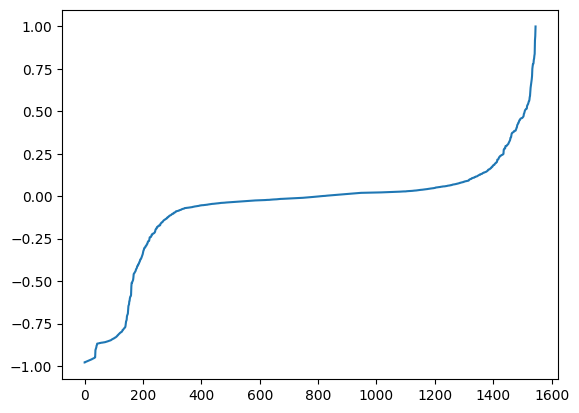

In [6]:
from matplotlib import pyplot as plt
plt.plot(Y)
plt.show

In [7]:
Y

array([-0.97930822, -0.97930822, -0.97701011, ...,  0.91878222,
        0.9434277 ,  1.        ])

In [6]:
canny = cv2.Canny(image,50,150)
cv2.imshow("edges",canny)
cv2.waitKey(0)

-1

In [1]:
'''
next iteration:

detect edges in the image using cv2.Canny - it works

but found labelling is still bad - need a cleaner set of images with more accurate labls

'''
import keras
import os
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, concatenate, Embedding, Reshape, Flatten, Activation
from keras.optimizers import SGD
import numpy as np

#constants to resize image to
HEIGHT = 360
WIDTH = 640

HEIGHT_REQUIRED_PORTION = 0.4 #bottom share, e.g. 0.1 is take lowest 10% of rows
WIDTH_REQUIRED_PORTION = 0.5

height_from = int(HEIGHT * (1 -HEIGHT_REQUIRED_PORTION))
width_from = int((WIDTH - WIDTH * WIDTH_REQUIRED_PORTION) / 2)
width_to = width_from + int(WIDTH_REQUIRED_PORTION * WIDTH)

#get a lsit of files
mypath = 'C:/SelfDrive/_out_ang'
only_images = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".png")]
only_steering = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".str")]
# get a list when both are available: image and steering
complete_names = set(only_images).intersection(only_steering)

# read training data 

X = [] #images
Y = [] #expected steering for this image
for example in complete_names:
    img_path = mypath+'/'+example+'.png'
    str_path = mypath+'/'+example+'.str'
     
    image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    # this version adds taking lower side of the image
    image = image[height_from:,width_from:width_to]
    canny = cv2.Canny(image,50,150)
    X.append(canny[:, :, None] / 255) # adding another dimension and normalising pixels to 0-1
    # max value of Y during writing of this was 0.79 so no need to convert it to 0-1
    
    f = open(str_path,'r')
    y = f.readline()
    Y.append(float(y))

X = np.array(X)
Y = np.array(Y)

#rescale Y
true_max = max(abs(min(Y)),max(Y))
Y *= (1.0/true_max)


model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())  
model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(1))

model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])


model.fit(X, Y, batch_size=32, shuffle=True, epochs=10, validation_split=0.2)

predictions = model.predict(X)
print("Prediction min: ",predictions.min()," Prediction max: ",predictions.max())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 144, 320, 64)      640       
                                                                 
 activation (Activation)     (None, 144, 320, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 72, 160, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 160, 64)       36928     
                                                                 
 activation_1 (Activation)   (None, 72, 160, 64)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 80, 64)       0         
 2D)                                                    

In [4]:
for i in range(100):
    print('Actual y: ', Y[i], " Predicted y: ",predictions[i])
    cv2.imshow('image',X[i])
    cv2.waitKey(0)

Actual y:  0.026695689127454302  Predicted y:  [0.01904392]
Actual y:  -0.034452578378351036  Predicted y:  [-0.00801484]
Actual y:  -0.0635703191796138  Predicted y:  [-0.00801484]
Actual y:  -0.03682277411554009  Predicted y:  [-0.00801484]
Actual y:  0.02490476214567218  Predicted y:  [-0.00801484]
Actual y:  -0.8529922140208334  Predicted y:  [-0.8791958]
Actual y:  0.025310756186033803  Predicted y:  [-0.00801484]
Actual y:  -0.15901812681179583  Predicted y:  [-0.00801484]
Actual y:  -0.9064379777702453  Predicted y:  [-0.8372764]
Actual y:  -0.9639917435230669  Predicted y:  [-0.8876209]
Actual y:  -0.03942189484121965  Predicted y:  [-0.05365211]
Actual y:  -0.36656835118358017  Predicted y:  [-0.40724316]
Actual y:  -0.0486648993488918  Predicted y:  [-0.00801484]
Actual y:  -0.7767171903694672  Predicted y:  [-0.74961716]
Actual y:  -0.0027066269357441707  Predicted y:  [-0.00801484]
Actual y:  0.42211997187131634  Predicted y:  [0.40339231]
Actual y:  0.05770048011008636  Pr

In [16]:
X[0].shape

(144, 320, 1)

In [1]:
s = '27364_-3'
val = s.split('_')[-1]
print(val)

-3


In [4]:
'''
a version of previous one but labels are taken from fine names
finding - need to position the camera differently so bonnet is not in view

'''

import os
import cv2
import numpy as np
import random

from tensorflow import keras

import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Input, Dropout, MaxPooling2D, Conv2D, concatenate, Embedding, Reshape, Flatten, Activation
from keras.optimizers import SGD

#constants to resize image to
HEIGHT = 360
WIDTH = 640

HEIGHT_REQUIRED_PORTION = 0.4 #bottom share, e.g. 0.1 is take lowest 10% of rows
WIDTH_REQUIRED_PORTION = 0.5

YAW_ADJ_DEGREES = 35 # e.g. goes from -35 to +35

height_from = int(HEIGHT * (1 -HEIGHT_REQUIRED_PORTION))
width_from = int((WIDTH - WIDTH * WIDTH_REQUIRED_PORTION) / 2)
width_to = width_from + int(WIDTH_REQUIRED_PORTION * WIDTH)

#get a lsit of files
mypath = 'C:/SelfDrive/_out_ang'
images = [f.split('.')[0] for f in os.listdir(mypath) if f.endswith(".png")]

random.shuffle(images)
# get a list when both are available: image and steering

# read training data 

X = [] #images
Y = [] #expected steering for this image
for example in images:
    img_path = mypath+'/'+example+'.png'
    image = cv2.imread(img_path,cv2.IMREAD_GRAYSCALE)
    # option to make images smaller
    image = cv2.resize(image, (WIDTH,HEIGHT))
    # this version adds taking lower side of the image
    image = image[height_from:,width_from:width_to]
    canny = cv2.Canny(image,50,150)
    X.append(canny[:, :, None] / 255) # adding another dimension and normalising pixels to 0-1
    # y labels are taken from after '_' in file name
    y = example.split('_')[-1]
    # convert to a fraction of 90 degrees so -1 is all the way left and + 1 is all the way right
    y = float(y)/YAW_ADJ_DEGREES # rescale to -1 to +1 so -1 is when max left 35degrees and +1 is +35deg
    Y.append(y)

X = np.array(X)
Y = np.array(Y)

#rescale Y
true_max = max(abs(min(Y)),max(Y))
Y *= (1.0/true_max)

model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())  
model.add(Dense(32))
model.add(Activation('relu'))

model.add(Dense(1))

model.summary()

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['MSE'])


model.fit(X, Y, batch_size=32, shuffle=False, epochs=10, validation_split=0.2)

predictions = model.predict(X)
print("Prediction min: ",predictions.min()," Prediction max: ",predictions.max())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 144, 320, 64)      640       
                                                                 
 activation_5 (Activation)   (None, 144, 320, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 72, 160, 64)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 160, 64)       36928     
                                                                 
 activation_6 (Activation)   (None, 72, 160, 64)       0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 80, 64)       0         
 2D)                                                  

In [6]:
model.save("lane_model_360x640_02_20", overwrite=True,include_optimizer=True,
    save_format=None, signatures=None, options=None, save_traces=True)

INFO:tensorflow:Assets written to: lane_model_360x640_02_20\assets


INFO:tensorflow:Assets written to: lane_model_360x640_02_20\assets


In [9]:
for i in range(100):
    print('Actual y: ', Y[i], " Predicted y: ",predictions[i])
    cv2.imshow('image',X[i])
    cv2.waitKey(0)

Actual y:  0.0  Predicted y:  [-0.03976538]
Actual y:  0.5142857142857142  Predicted y:  [0.4549619]
Actual y:  -0.19999999999999998  Predicted y:  [-0.28337932]
Actual y:  -0.4285714285714285  Predicted y:  [-0.492609]
Actual y:  -0.5428571428571428  Predicted y:  [-0.56820077]
Actual y:  0.0  Predicted y:  [-0.00050758]
Actual y:  -0.657142857142857  Predicted y:  [-0.70105684]
Actual y:  -0.8285714285714285  Predicted y:  [-0.84249157]
Actual y:  0.14285714285714282  Predicted y:  [0.18693627]
Actual y:  0.0857142857142857  Predicted y:  [0.05673605]
Actual y:  0.0  Predicted y:  [-0.033412]
Actual y:  0.3428571428571428  Predicted y:  [0.3264245]
Actual y:  0.19999999999999998  Predicted y:  [0.17185964]
Actual y:  -0.657142857142857  Predicted y:  [-0.69270307]
Actual y:  0.4285714285714285  Predicted y:  [0.44365215]
Actual y:  0.0  Predicted y:  [-0.08101199]
Actual y:  0.6  Predicted y:  [0.6132954]
Actual y:  -0.8857142857142856  Predicted y:  [-0.8849879]
Actual y:  -0.457142